<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/3%20action%20deep%20q%20regularized%20i%20forgot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
!pip install pandas_ta
!pip install tf_agents[reverb]

In [41]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import reverb
import random

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.policies import greedy_policy
from tf_agents.policies.epsilon_greedy_policy import EpsilonGreedyPolicy
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

In [42]:
num_iterations = 20000000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 1000  # @param {type:"integer"}

num_eval_episodes = 3  # @param {type:"integer"}
eval_interval = 100000  # @param {type:"integer"}

In [43]:
def get_relative_change(df, column_name):
    relative_changes = []
    for i in range(len(df)):
        if i == 0:
            relative_changes.append(0)  # First element has no previous value
        else:
            relative_change = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1]
            relative_changes.append(relative_change)
    return pd.DataFrame({column_name: relative_changes})

In [44]:
df = pd.read_csv('/content/drive/MyDrive/eurusd_hour.csv')
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']


In [45]:
RSI = ta.rsi(close,14,scalar=1)
AROON = ta.aroon(high,low,14,scalar = 1)
AROON_UP = AROON['AROOND_14']
AROON_DOWN = AROON['AROONU_14']
CCI = ta.cci(high,low,close,14)
CCI = CCI.multiply(.001)
CCI = CCI.add(.5)
RVI = ta.rvi(close,high,low,14,scalar=1)
CHANGE = get_relative_change(close,"Change")

sma = ta.sma(close,20,offset = -20)
sma2 = ta.sma(close,30,offset = -20)
DIFF = sma-sma2
DIFF = DIFF/np.std(DIFF)
DIFF.name = 'DIFF'

INDICATORS = pd.concat([CHANGE,RSI,AROON_UP,AROON_DOWN,CCI,RVI,DIFF],axis=1)

INDICATORS = INDICATORS.dropna(axis=0)
INDICATORS = INDICATORS.reset_index()

change = INDICATORS.pop('Change')
diff = INDICATORS.pop('DIFF')
INDICATORS.pop('index')

INDICATORS = INDICATORS.to_numpy()
change = change.to_numpy()
change_dev = change.std()
change = change/change_dev
np.set_printoptions(suppress=True)

0.10848537423653505
(93050,)


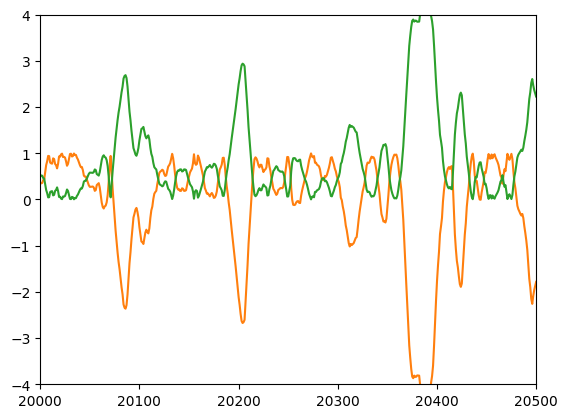

In [46]:
diff_adj = ((abs(diff)*-1.25)+1)
print(np.mean(diff_adj))
plt.xlim(20000,20500)
plt.ylim(-4,4)

print(diff.shape)
plt.plot(np.cumsum(change))
plt.plot(diff_adj)
plt.plot(abs(diff))

-0.00659753394752164
0.00659753394752164


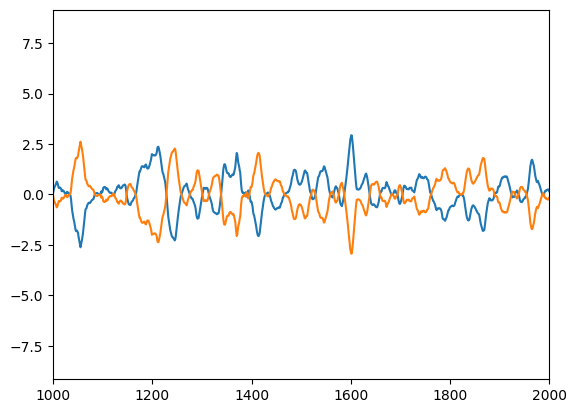

In [47]:
buy_sig = diff
sell_sig = (-diff)

plt.xlim(1000,2000)
sig_dict = {
    'buy': buy_sig,
    'sell': sell_sig,
}

print(np.mean(buy_sig))
print(np.mean(sell_sig))
plt.plot(sig_dict['buy'])
plt.plot(sig_dict['sell'])

In [48]:
print(INDICATORS)

[[0.38187407 1.         0.71428571 0.39334634 0.85330187]
 [0.52438576 0.92857143 0.64285714 0.42260631 0.87272338]
 [0.45394255 0.85714286 0.57142857 0.38867102 0.75057577]
 ...
 [0.52805713 0.71428571 0.07142857 0.48937919 0.62023368]
 [0.5497583  0.64285714 0.         0.56455544 0.65215905]
 [0.5714324  0.57142857 0.         0.63083612 0.67453355]]


(5400.0, 5500.0)

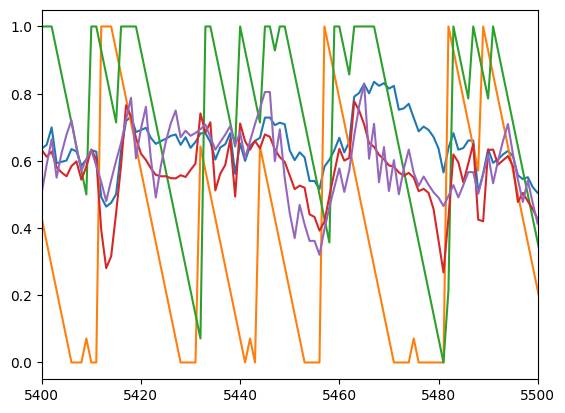

In [49]:
plt.plot(INDICATORS)
plt.xlim(5400,5500)
#print(INDICATORS)

In [50]:
def custom_formatter(x):
  return f'{x:.4f}'


def test_environment(env, num_steps):
    # Reset the environment
    observation = env.reset()

    # Get the upper bound of the action range
    action_spec = env.action_spec().maximum

    # Loop through the time steps and take random actions
    for _ in range(num_steps):
        # Select a random action from the range of valid values
        action = random.randint(0, action_spec)

        # Execute the action and get the next observation, reward, done, and info
        observation, reward, done, info = env.step(action)

        # Print the current time step
        np.set_printoptions(formatter={'float_kind':custom_formatter})
        print(action,"{:.4f}".format(reward),info[5:8])


In [211]:
def cross(cur_diff,prev_diff):
  if cur_diff > 0 and prev_diff <= 0:
    return 5
  elif cur_diff < 0 and prev_diff >= 0:
    return 5
  else:
    return 0


In [51]:
max_ep_len = 1000

In [301]:
class TradingEnv(py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int64, minimum=0, maximum=3, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(8,), dtype=np.float32, minimum=-100,maximum=100, name='observation')


    self._state = [0] * 8
    self._episode_ended = False
    self._count = random.randint(0,60000)
    self._end_ep = self._count+max_ep_len
    self._balance = 0
    self._prev_dff = 0
    self.trade_info = {
    'time': 0,
    'value': 0,
    'direction': 0
    }


  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def get_balance(self):
    return self._balance

  def _reset(self):

    self._state = [0] * 8
    self._episode_ended = False
    self._count = random.randint(0,60000)
    self._end_ep = self._count+max_ep_len
    self._balance = 0
    self._prev_diff = 0
    self.trade_info = {
    'time': 0,
    'value': 0,
    'direction': 0,
    }

    return ts.restart(np.array(self._state, dtype=np.float32))

  def _step(self, action):

    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start
      # a new episode.
      return self.reset()


    mult = 10
    cur_diff = diff[self._count]
    self._prev_diff = cur_diff
    entry_bonus = cross(cur_diff,self._prev_diff)
    profit = 0
    reward = 0
    cur_change = change[self._count]/mult

    cur_direction = self.trade_info['direction']

    if action == 0:
      profit = self.trade_info['value']-.01
      self.trade_info['value'] = cur_change
      self.trade_info['direction'] = 1
      self.trade_info['time'] = 0
      reward = ((profit*mult) + cur_diff)+ entry_bonus
    elif action == 1:
      profit = self.trade_info['value']-.01
      self.trade_info['value'] = -cur_change
      self.trade_info['direction'] = -1
      self.trade_info['time'] = 0
      reward = ((profit*mult) + -cur_diff)+ -entry_bonus
    elif action == 2:
      profit = self.trade_info['value']
      self.trade_info['value'] = 0
      self.trade_info['direction'] = 0
      self.trade_info['time'] = 0 if cur_direction != 0 else self.trade_info['time'] + .01
      reward = profit*mult
    else:
      self.trade_info['value'] = cur_change*cur_direction
      self.trade_info['time'] += .01
      reward = cur_diff*cur_direction



    self._balance += profit

    info_list = [
        self.trade_info['value'],
        self.trade_info['direction'],
        self.trade_info['time']
    ]


    #update state
    self._state = np.append(INDICATORS[self._count],info_list)

    if self._count >= self._end_ep:
      self._episode_ended = True

    self._count += 1

    if self._episode_ended:
      reward = (self._balance+self.trade_info['value'])*mult
      return ts.termination(np.array(self._state, dtype=np.float32), reward=reward)
    else:
      return ts.transition(
          np.array(self._state, dtype=np.float32), reward=reward, discount=.5)

In [302]:
env = TradingEnv()

utils.validate_py_environment(env, episodes=2)

In [303]:
test_environment(env,100)

0 -0.1461 [0.0000 1.0000 0.0000]
3 0.0282 [-0.0473 1.0000 0.0100]
3 0.0761 [0.0328 1.0000 0.0200]
1 0.1003 [0.0284 -1.0000 0.0000]
0 0.3672 [-0.0069 1.0000 0.0000]
0 0.0356 [0.0366 1.0000 0.0000]
0 0.4935 [-0.0252 1.0000 0.0000]
1 -0.6184 [-0.0517 -1.0000 0.0000]
1 -0.9251 [0.0006 -1.0000 0.0000]
1 -0.4667 [0.0542 -1.0000 0.0000]
3 -0.3854 [-0.0972 -1.0000 0.0100]
2 -0.9718 [0.0000 0.0000 0.0000]
3 0.0000 [-0.0000 0.0000 0.0100]
1 -0.4193 [0.0353 -1.0000 0.0000]
2 0.3528 [0.0000 0.0000 0.0000]
1 -0.5984 [-0.0272 -1.0000 0.0000]
1 -0.9473 [-0.0259 -1.0000 0.0000]
0 0.3091 [0.0000 1.0000 0.0000]
3 0.7295 [0.0637 1.0000 0.0100]
2 0.6373 [0.0000 0.0000 0.0000]
0 0.5455 [0.0340 1.0000 0.0000]
3 0.6501 [-0.0359 1.0000 0.0100]
0 0.1845 [0.0038 1.0000 0.0000]
2 0.0378 [0.0000 0.0000 0.0000]
2 0.0000 [0.0000 0.0000 0.0100]
3 0.0000 [0.0000 0.0000 0.0200]
3 0.0000 [0.0000 0.0000 0.0300]
3 0.0000 [0.0000 0.0000 0.0400]
2 0.0000 [0.0000 0.0000 0.0500]
3 0.0000 [-0.0000 0.0000 0.0600]
1 -0.0855 [0.

In [304]:
train_py_env = env
eval_py_env = env
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [305]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)


In [306]:
fc_layer_params = (20, 5)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1


In [307]:
def activity_regularizer(multiplier):
    def regularizer(y_pred):
        mean = tf.reduce_mean(y_pred)
        variance = tf.math.reduce_variance(y_pred)
        return multiplier * (tf.square(mean - 0) + tf.square(variance - 1))
    return regularizer

In [308]:
def activity_regularizer(multiplier, decay=0.99):
    # Initialize moving averages for mean and variance
    mean_avg = tf.Variable(0.0, trainable=False, name='mean_avg')
    variance_avg = tf.Variable(1.0, trainable=False, name='variance_avg')

    def regularizer(y_pred):
        # Calculate the current mean and variance
        current_mean = tf.reduce_mean(y_pred)
        current_variance = tf.math.reduce_variance(y_pred)

        # Update moving averages
        update_mean = tf.compat.v1.assign(mean_avg, decay * mean_avg + (1 - decay) * current_mean)
        update_variance = tf.compat.v1.assign(variance_avg, decay * variance_avg + (1 - decay) * current_variance)

        with tf.control_dependencies([update_mean, update_variance]):
            # Use the moving averages for regularization
            mean = mean_avg
            variance = variance_avg

        return multiplier * (tf.square(mean - 0) + tf.square(variance - 1))

    return regularizer

In [309]:
drop_val = .2
lars_coefficient = .01
reg = tf.keras.regularizers.L2(.01)
q_net = sequential.Sequential([
    layers.Dense(100,activation='gelu', activity_regularizer=activity_regularizer(0.01)),
    layers.Dropout(drop_val),
    layers.Dense(50,activation='gelu',activity_regularizer=activity_regularizer(0.01)),
    layers.Dropout(drop_val),
    layers.Dense(20,activation='gelu',activity_regularizer=activity_regularizer(0.01)),
    layers.Dropout(drop_val),
    layers.Dense(num_actions,activation=None,kernel_regularizer=reg, bias_regularizer=reg)
])

In [335]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    epsilon_greedy = .1,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [336]:
eval_policy = agent.policy

collect_policy = agent.collect_policy

In [312]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [313]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [314]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        last_reward = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            last_reward = time_step.reward  # Store the last reward of the episode
            episode_return = last_reward  # Update episode_return with the last reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


In [337]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

In [316]:
agent.collect_data_spec
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [317]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'discount': array(0.5000, dtype=float32),
  'observation': array([0.4898, 0.0714, 0.9286, 0.4993, 0.5439, 0.0000, 0.0000, 0.0000],
       dtype=float32),
  'reward': array(-0.4340, dtype=float32),
  'step_type': array(1, dtype=int32)}),
 ())

In [338]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<_PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 8), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [319]:
iterator = iter(dataset)
print(iterator)

In [320]:
global_step = tf.compat.v1.train.get_global_step()

In [321]:
"""
from tensorflow.python.training.training import global_step
checkpoint_dir = '/tmp/checkpointer'
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
)
"""

"\nfrom tensorflow.python.training.training import global_step\ncheckpoint_dir = '/tmp/checkpointer'\ntrain_checkpointer = common.Checkpointer(\n    ckpt_dir=checkpoint_dir,\n    max_to_keep=1,\n    agent=agent,\n    policy=agent.policy,\n    replay_buffer=replay_buffer,\n)\n"

In [ ]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)



for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))
    #train_checkpointer.save(0)

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 1000: loss = 0.8373887538909912
step = 2000: loss = 1.8454325199127197


In [ ]:
def compute_avg_return_print(environment, policy, num_episodes=10):

  total_return = 0.0
  for episode in range(num_episodes):
    balance_arr = []
    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      obs = time_step.observation.numpy()

      balance = env.get_balance()
      balance_arr.append(balance)
      # Print the episode number and observation at each step
      print(f"Episode {episode + 1}: Observation = {obs}")

      episode_return += time_step.reward
    plt.plot(balance_arr)
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [324]:
avg_return = compute_avg_return_print(eval_env, collect_policy, num_eval_episodes)
print(avg_return)

Episode 1: Observation = [[0.4988 0.0000 0.5000 0.5049 0.4981 -0.0000 0.0000 0.0100]]
Episode 1: Observation = [[0.4639 0.0000 0.4286 0.4384 0.4552 -0.0000 0.0000 0.0200]]
Episode 1: Observation = [[0.4331 0.2143 0.3571 0.3201 0.4094 -0.0393 1.0000 0.0000]]
Episode 1: Observation = [[0.4529 0.1429 0.2857 0.3658 0.4748 0.0199 1.0000 0.0100]]
Episode 1: Observation = [[0.4459 0.0714 0.2143 0.3750 0.4203 0.0083 -1.0000 0.0000]]
Episode 1: Observation = [[0.4520 0.0000 0.1429 0.4132 0.4908 -0.0055 -1.0000 0.0100]]
Episode 1: Observation = [[0.4552 0.8571 0.0714 0.4114 0.5535 -0.0028 -1.0000 0.0200]]
Episode 1: Observation = [[0.4587 0.7857 0.0000 0.4348 0.6081 -0.0028 -1.0000 0.0300]]
Episode 1: Observation = [[0.3968 1.0000 0.0000 0.3868 0.5326 -0.0637 1.0000 0.0000]]
Episode 1: Observation = [[0.2716 1.0000 0.0000 0.2122 0.4155 -0.2022 1.0000 0.0100]]
Episode 1: Observation = [[0.1946 1.0000 0.0714 0.1679 0.2837 -0.2360 1.0000 0.0200]]
Episode 1: Observation = [[0.1492 1.0000 0.0000 0.24

KeyboardInterrupt: ignored

Episode 1: Observation = [[0.5453 0.4286 0.6429 0.5555 0.4353 -0.0000 0.0000 0.0100]]
Episode 1: Observation = [[0.5207 0.3571 0.5714 0.5328 0.3663 -0.0314 1.0000 0.0000]]
Episode 1: Observation = [[0.5011 0.2857 0.5000 0.5236 0.3103 -0.0254 1.0000 0.0100]]
Episode 1: Observation = [[0.5302 0.2143 0.4286 0.5315 0.4135 -0.0386 -1.0000 0.0000]]
Episode 1: Observation = [[0.5418 0.1429 0.3571 0.5457 0.4976 -0.0157 -1.0000 0.0100]]
Episode 1: Observation = [[0.5219 0.0714 0.2857 0.5383 0.4341 -0.0223 1.0000 0.0000]]
Episode 1: Observation = [[0.5951 0.0000 1.0000 0.6320 0.4952 0.1020 1.0000 0.0100]]
Episode 1: Observation = [[0.6013 0.0000 0.9286 0.6877 0.5445 0.0096 1.0000 0.0000]]
Episode 1: Observation = [[0.6724 0.0000 1.0000 0.7787 0.5899 0.1266 1.0000 0.0000]]
Episode 1: Observation = [[0.6510 0.0000 0.9286 0.6913 0.5179 -0.0217 1.0000 0.0000]]
Episode 1: Observation = [[0.5570 0.5000 0.8571 0.5806 0.4538 -0.1066 1.0000 0.0100]]
Episode 1: Observation = [[0.5238 0.4286 0.7857 0.4926 

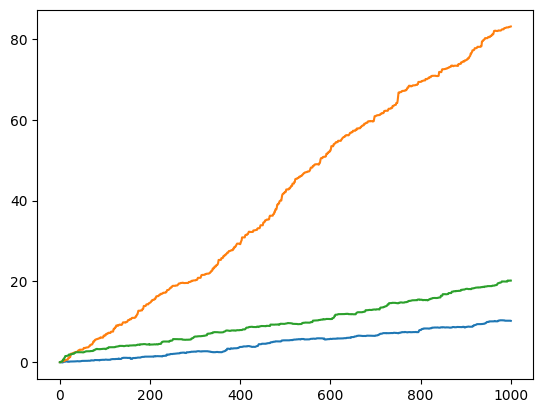

In [341]:
avg_return = compute_avg_return_print(eval_env, eval_policy, num_eval_episodes)
print(avg_return)

In [340]:
weights = q_net.get_weights()
print(weights)

[array([[0.1953, -1.0732, -0.4217, 0.2614, 0.5120, 0.6238, -1.4746,
        0.0464, 0.5984, 0.5274, -0.7236, -0.0477, -0.0431, -0.2354,
        0.6036, 0.0653, 0.3324, -0.2769, -0.5363, 0.1279, -0.9470,
        -0.2073, 0.0921, -0.0359, 0.2746, -1.8620, -0.4678, -0.0000,
        0.1343, -0.2588, -1.4071, -0.4871, -0.2085, 0.5457, 0.4430,
        -0.3441, -0.6073, 0.4613, -1.1591, 0.2819, -0.1662, -0.2420,
        0.3876, 1.0050, 0.2475, 0.2525, 0.8207, -0.2008, -0.4390, 0.2390,
        0.0460, -0.0253, -1.4188, 0.2954, 0.0261, 0.1934, -0.7180,
        0.2979, -0.2454, -0.0942, -1.7045, -0.4155, 0.1799, -0.3239,
        0.6966, -0.5710, -0.6795, -0.3415, 0.0740, -0.1443, 0.3852,
        0.5186, 0.2965, -0.4471, 0.4294, 0.0220, -0.1796, -0.0735,
        0.3003, -0.6268, 0.6408, -0.0288, -1.9264, -0.7066, -0.1596,
        -0.3975, -0.5572, 0.3299, -0.1036, 0.0211, 0.1709, -0.1310,
        0.5321, -0.4365, 0.1720, -0.7575, -0.0311, 0.1402, -0.0244,
        -1.5706],
       [-0.0117, 0.7161

In [ ]:
content/drive/MyDrive